In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from tensorflow.keras import utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path= '/content/drive/MyDrive/eye_blink_detector_test/dataset/'
x_train = np.load(data_path+'x_train.npy').astype(np.float32)
y_train = np.load(data_path+'y_train.npy').astype(np.float32)
x_val = np.load(data_path+'x_val.npy').astype(np.float32)
y_val = np.load(data_path+'y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


# Preview

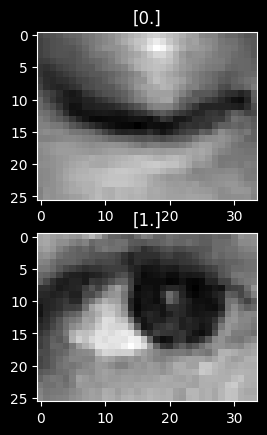

In [ ]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[1]))
plt.imshow(x_train[6].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[0]))
plt.imshow(x_val[3].reshape((26, 34)), cmap='gray')

In [ ]:
a=np.array(x_train)
print(a)

[[[[ 51.]
   [ 53.]
   [ 51.]
   ...
   [ 63.]
   [ 62.]
   [ 60.]]

  [[ 48.]
   [ 43.]
   [ 36.]
   ...
   [ 73.]
   [ 67.]
   [ 74.]]

  [[ 30.]
   [ 28.]
   [ 28.]
   ...
   [121.]
   [112.]
   [107.]]

  ...

  [[113.]
   [117.]
   [118.]
   ...
   [163.]
   [164.]
   [164.]]

  [[121.]
   [125.]
   [119.]
   ...
   [166.]
   [166.]
   [160.]]

  [[128.]
   [132.]
   [126.]
   ...
   [167.]
   [164.]
   [158.]]]


 [[[193.]
   [196.]
   [200.]
   ...
   [204.]
   [202.]
   [202.]]

  [[192.]
   [194.]
   [197.]
   ...
   [199.]
   [197.]
   [197.]]

  [[187.]
   [186.]
   [188.]
   ...
   [186.]
   [188.]
   [188.]]

  ...

  [[154.]
   [148.]
   [149.]
   ...
   [186.]
   [184.]
   [185.]]

  [[162.]
   [165.]
   [168.]
   ...
   [190.]
   [188.]
   [188.]]

  [[181.]
   [183.]
   [185.]
   ...
   [192.]
   [193.]
   [193.]]]


 [[[ 64.]
   [ 72.]
   [ 76.]
   ...
   [ 65.]
   [ 68.]
   [ 73.]]

  [[ 65.]
   [ 73.]
   [ 77.]
   ...
   [ 63.]
   [ 67.]
   [ 72.]]

  [[ 68.]
   [ 7

# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.5,
    shear_range=0.4,
    zoom_range = [0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

# Build Model

In [ ]:
inputs = Input(shape=(26, 34, 1))

x = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
outputs = Activation('sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 17, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

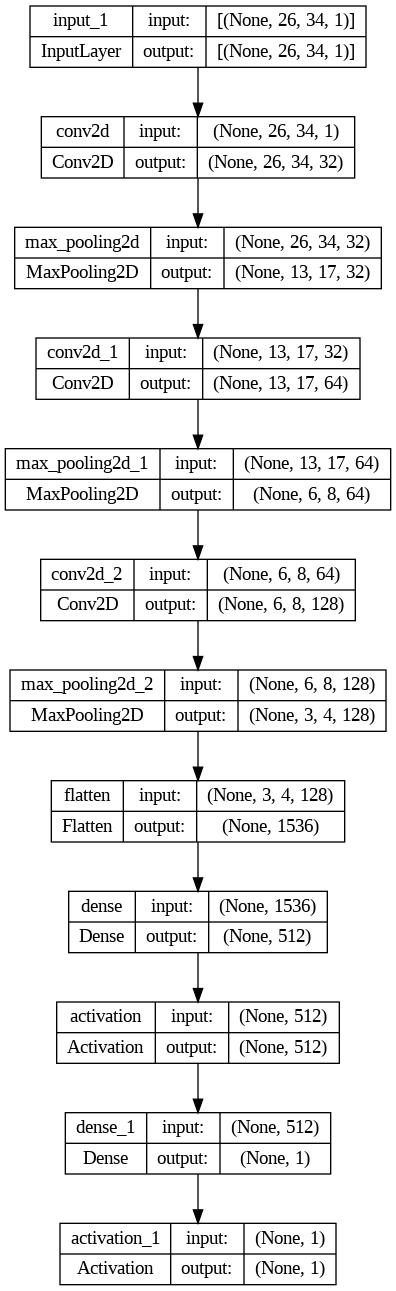

In [ ]:
from tensorflow.keras.utils import plot_model

utils.plot_model(model, to_file= '/content/drive/MyDrive/eye_blink_detector_test/videos/model.png',show_shapes =True)

# Train

In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50


<ipython-input-9-303b1247d547>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


78/81 [===========================>..] - ETA: 0s - loss: 0.5963 - acc: 0.6855
Epoch 1: val_acc improved from -inf to 0.81597, saving model to models/2024_06_08_11_49_12.h5
81/81 [==============================] - 7s 21ms/step - loss: 0.5936 - acc: 0.6883 - val_loss: 0.4240 - val_acc: 0.8160 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
77/81 [===========================>..] - ETA: 0s - loss: 0.4628 - acc: 0.7950
Epoch 2: val_acc improved from 0.81597 to 0.84722, saving model to models/2024_06_08_11_49_12.h5
81/81 [==============================] - 1s 14ms/step - loss: 0.4674 - acc: 0.7916 - val_loss: 0.3734 - val_acc: 0.8472 - lr: 0.0010
Epoch 3/50
79/81 [============================>.] - ETA: 0s - loss: 0.4041 - acc: 0.8263
Epoch 3: val_acc improved from 0.84722 to 0.88889, saving model to models/2024_06_08_11_49_12.h5
81/81 [==============================] - 1s 15ms/step - loss: 0.4055 - acc: 0.8256 - val_loss: 0.2793 - val_acc: 0.8889 - lr: 0.0010
Epoch 4/50
81/81 [==============================] - ETA: 0s - loss: 0.3716 - acc: 0.8503
Epoch 4: val_acc improved from 0.88889 to 0.89236, saving model to models/2024_06_08_11_49_12.h5
81/81 [==============================] - 2s 22ms/step - loss: 0.3716 - acc: 0.8503 - val_loss: 0.2882 - val_acc: 0.8924 - lr: 0.0010
Epoch 5/50
81/81 [=========================

#ROC-AUC 곡선

9/9 [==============================] - 0s 3ms/step
ROC AUC: 0.9705215419501135


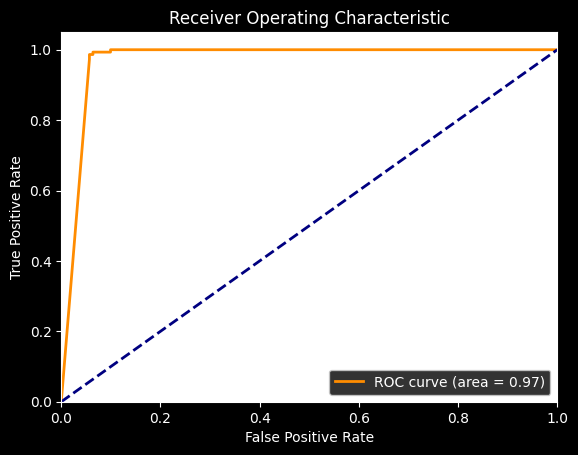

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_val는 이진 분류기의 확률 예측입니다.
# 일반적으로 sklearn의 predict_proba 메서드를 사용하여 생성되며,
# 이 메서드는 각 클래스에 대한 확률을 반환합니다.

y_pred = model.predict(x_val)[:, 0]

#roc_auc_score 함수를 사용하여 ROC AUC를 계산할 수 있습니다.
roc_auc = roc_auc_score(y_val, y_pred)

print(f"ROC AUC: {roc_auc}")

# y_true는 실제 클래스 레이블, y_pred는 모델이 예측한 확률 또는 점수
fpr, tpr, _ = roc_curve(y_val, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.gca().set_facecolor('white')
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix

9/9 [==============================] - 0s 2ms/step
test acc: 1.0


<Axes: >

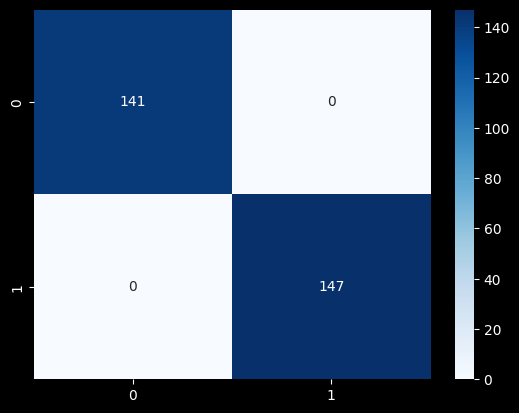

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int64)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Distribution of Prediction

<ipython-input-12-8f616a09dfd0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_pred, kde=False)


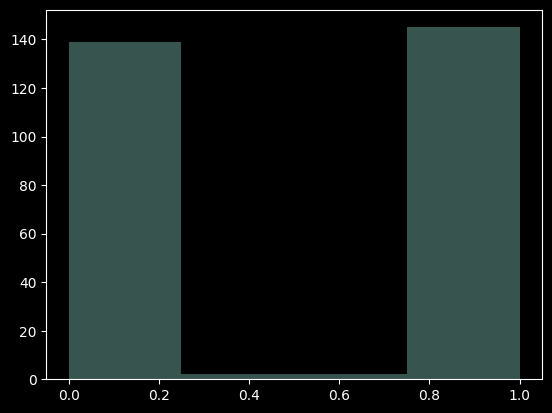

In [ ]:
ax = sns.distplot(y_pred, kde=False)

##전방주시 경고, 졸음 경고, 눈 깜박이 경고

In [ ]:

import cv2
from google.colab.patches import cv2_imshow
import dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model
from IPython.display import display, Image, clear_output
import os
from IPython.display import display, Image as IPImage
import PIL.Image as Image
from PIL import ImageFont, ImageDraw

IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/eye_blink_detector_test/shape_predictor_68_face_landmarks.dat')

model = load_model('/content/models/2024_06_08_11_49_12.h5')

font_path = '/content/drive/MyDrive/eye_blink_detector_test/NanumGothic.otf'  # change this to the path of your Korean font file
font = ImageFont.truetype(font_path, 20)

def putTextWithPIL(image, text, pos, color):
    # convert OpenCV image to PIL image
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image_pil)
    draw.text(pos, text, font=font, fill=color)
    # convert PIL image back to OpenCV image
    image_cv = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    return image_cv

def crop_eye(img, eye_points):
    if len(eye_points) < 2:  # 눈의 좌표가 충분하지 않은 경우
        return np.array([]), np.array([])  # 빈 배열 반환

    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    w = (x2 - x1) * 1.2
    h = w * IMG_SIZE[1] / IMG_SIZE[0]

    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(int)

    eye_img = img[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

    if eye_img.size == 0:  # 잘라낸 이미지가 비어 있는 경우
        return np.array([]), np.array([])  # 빈 배열 반환

    return eye_img, eye_rect


capture = cv2.VideoCapture('/content/drive/MyDrive/eye_blink_detector_test/videos/sleep_eye.mp4')
frame_size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fps = capture.get(cv2.CAP_PROP_FPS)
print("Frames per second: ", fps) #프래임 속도 측정

ret, img_ori = capture.read()
if not ret:
    print("영상문제")
    exit()

out = cv2.VideoWriter('output_11.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size )

fname = 'frame.png'
BLINK_THRESHOLD = 0.1  # 임계값
BLINK_DURATION = 45  # 1.5초 (30fps 기준)
sleep_warning_count = 0

blink_l_counter = 0
blink_r_counter = 0
blink_warning_count = 0
blink_warning_count_2 = 0
frame_warning_threshold = 7
diff_threshold=0.6
eye_none=0
keep_front = 0
frame_count = 0
angle=0
angle_warning=0


while ret:
  img_ori = cv2.resize(img_ori, dsize=(frame_size[0], frame_size[1]), fx=1, fy=1)

  img = img_ori.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
      shapes = predictor(gray, face)
      shapes = face_utils.shape_to_np(shapes)

      eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
      eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])
      if len(eye_rect_l)<2 or len(eye_img_r)<2:
         continue
      eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
      eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
      eye_img_r = cv2.flip(eye_img_r, flipCode=1)

      eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
      eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

      pred_l = model.predict(eye_input_l)
      pred_r = model.predict(eye_input_r)

      state_l = '%.1f' % pred_l if pred_l>0.1 else '%.1f' % pred_l
      state_r = '%.1f' % pred_r if pred_r>0.1  else '%.1f' % pred_r

      # 프레임에 경계 상자 및 예측 상태 그리기
      cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(0,255,255), thickness=1)
      cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(0,255,255), thickness=1)
      cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1)
      cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1)
      dif_l = (tuple(eye_rect_l[0:2])[1] + tuple(eye_rect_l[2:4])[1]) // 2
      dif_r = (tuple(eye_rect_r[0:2])[1] + tuple(eye_rect_r[2:4])[1]) // 2
      # 눈의 기울기가 0.5배 차이가 나면 경고
      if dif_l <= tuple(eye_rect_r[0:2])[1] or dif_r <= tuple(eye_rect_l[0:2])[1]:
          angle+=1
          if angle==frame_warning_threshold:
            img = putTextWithPIL(img, '위험! 전방을 주시 해주세요', (10, 60), color=(0, 255, 0))
            angle_warning+=1
            angle=0

    # 두눈이 프래임 마다 감겨 있으면 blink_l_counter +1 --> BLINK_DURATION 임계치 만큼 증가 후 초기화
      if pred_l <= BLINK_THRESHOLD and pred_r <= BLINK_THRESHOLD:
        if blink_l_counter < BLINK_DURATION and blink_r_counter < BLINK_DURATION:
          blink_l_counter += 1
          blink_r_counter += 1
        elif blink_l_counter == BLINK_DURATION and blink_r_counter == BLINK_DURATION:
          blink_l_counter = 0
          blink_r_counter =0
      elif pred_l > BLINK_THRESHOLD and pred_r > BLINK_THRESHOLD:
        blink_l_counter = 0
        blink_r_counter = 0

      # 두 눈 모두 지속적으로 감겨 있으면 '위험! 자고 있습니다.' 메시지 출력
      if (blink_l_counter == BLINK_DURATION) and (blink_r_counter == BLINK_DURATION):
        img = putTextWithPIL(img, '위험! 자고 있습니다.', (10, 30), color=(255, 0, 0))
        sleep_warning_count += 1

      if abs(pred_l - pred_r) > diff_threshold:
        blink_warning_count+=1
      elif abs(pred_l - pred_r) < diff_threshold:
        blink_warning_count = 0

      #예측의 차이가 임계값(0.7)보다 크고  경고 메시지를 표시.
      if blink_warning_count==frame_warning_threshold:
        blink_warning_count_2 +=1
        img = putTextWithPIL(img, '위험! 졸고 있습니다.', (10, 30), color=(0,0,255))

  # 마지막 프레임에 횟수 결과 출력
  img = putTextWithPIL(img, f'졸음 경고 횟수: {int(sleep_warning_count)}', (10, 150), color=(255,0,0))
  img = putTextWithPIL(img, f'눈 깜빡임 경고 횟수: {int(blink_warning_count_2)}', (10, 180), color=(255,0,0))
  img = putTextWithPIL(img, f'전방 주시 경고 횟수: {int(angle_warning)}', (10, 210), color=(255,0,0))
  img = putTextWithPIL(img,f'fps: {int(fps)}', (10, 240), color=(255,0,0))
  img = putTextWithPIL(img,f'frame_warning_threshold: {int(frame_warning_threshold)}', (10, 270), color=(255,0,0))
  img = putTextWithPIL(img,f'diff_threshold: {float(diff_threshold)}', (10, 300), color=(255,0,0))

  out.write(img)

  #### 동영상 출력없이 저장####
  clear_output(wait=True)
  cv2.imwrite(fname, img)
  display(IPImage(fname))
  cv2_imshow(img)
  cv2.waitKey(1)
  #### 동영상 출력없이 저장 ####

  #cv2.imwrite(f'frame_{frame_count}.png', img)  # 각 프레임을 이미지로 저장
  #frame_count += 1
  ret, img_ori = capture.read()


capture.release()
out.release()

if out.isOpened():
    print("Warning")
cv2.destroyAllWindows()

if os.path.exists(fname):  # 파일이 존재하는지 확인
    os.remove(fname)  # 마지막 이미지 파일 제거

## test_data

In [ ]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model
from IPython.display import display, Image, clear_output
import os
from IPython.display import display, Image as IPImage
import PIL.Image as Image
from PIL import ImageFont, ImageDraw

IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/eye_blink_detector_test/shape_predictor_68_face_landmarks.dat')

model = load_model('/content/models/2024_06_08_11_49_12.h5')

font_path = '/content/drive/MyDrive/eye_blink_detector_test/NanumGothic.otf'
font = ImageFont.truetype(font_path, 20)

def putTextWithPIL(image, text, pos, color):
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image_pil)
    draw.text(pos, text, font=font, fill=color)
    image_cv = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    return image_cv

def crop_eye(img, eye_points):
    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    w = (x2 - x1) * 1.2
    h = w * IMG_SIZE[1] / IMG_SIZE[0]

    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int64)

    eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

    return eye_img, eye_rect

capture = cv2.VideoCapture('/content/drive/MyDrive/eye_blink_detector_test/videos/test_prob.mp4')
frame_size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fps = capture.get(cv2.CAP_PROP_FPS)
print("Frames per second: ", fps) #프래임 속도 측정

ret, img_ori = capture.read()
if not ret:
    print("영상 문제 ...")
    exit()

out = cv2.VideoWriter('test_output1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps,frame_size)

fname = 'frame2.png'

BLINK_THRESHOLD = 0.1  # 임계값
BLINK_DURATION = 45  # 1.5초 (30fps 기준)
sleep_warning_count = 0

blink_l_counter = 0
blink_r_counter = 0
blink_warning_count = 0
blink_warning_count_2 = 0
blink_warning_threshold = 7
diff_threshold=0.6
eye_none = 0
keep_front = 0

while ret:

    img_ori = cv2.resize(img_ori, dsize=(frame_size[0], frame_size[1]), fx=1, fy=1)

    img = img_ori.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)

    for face in faces:
        shapes = predictor(gray, face)
        shapes = face_utils.shape_to_np(shapes)

        eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
        eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])
        if not eye_img_l.any() or not eye_img_r.any():
          eye_none+=1
          continue


        eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
        eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
        eye_img_r = cv2.flip(eye_img_r, flipCode=1)

        eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
        eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

        pred_l = model.predict(eye_input_l)
        pred_r = model.predict(eye_input_r)

        state_l = '%.1f' % pred_l if pred_l > 0.1 else '%.1f' % pred_l
        state_r = '%.1f' % pred_r if pred_r > 0.1 else '%.1f' % pred_r

        # 프레임에 경계 상자 및 예측 상태 그리기
        cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(0,255,255), thickness=1)
        cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(0,255,255), thickness=1)
        cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1)
        cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1)

        # 한쪽 눈이 감지되지 않으면 경고를 표시하고 다음 프레임으로 계속 진행합니다.
        if eye_none==2:
          eye_none=0
          img = putTextWithPIL(img, '위험! 전방을 주시해 주세요.', (10, 30), color=(0, 255,0))
          keep_front+=1

        # 두눈이 프래임 마다 감겨 있으면 blink_l_counter +1 --> BLINK_DURATION 임계치 만큼 증가 후 초기화
        if pred_l <= BLINK_THRESHOLD and pred_r <= BLINK_THRESHOLD:
          if blink_l_counter < BLINK_DURATION and blink_r_counter < BLINK_DURATION:
            blink_l_counter += 1
            blink_r_counter += 1
          elif blink_l_counter == BLINK_DURATION and blink_r_counter == BLINK_DURATION:
            blink_l_counter = 0
            blink_r_counter =0
        elif pred_l > BLINK_THRESHOLD and pred_r > BLINK_THRESHOLD:
          blink_l_counter = 0
          blink_r_counter = 0

        # 두 눈 모두 지속적으로 감겨 있으면 '위험! 자고 있습니다.' 메시지 출력
        if (blink_l_counter == BLINK_DURATION) and (blink_r_counter == BLINK_DURATION):
          img = putTextWithPIL(img, '위험! 자고 있습니다.', (10, 30), color=(255, 0, 0))
          sleep_warning_count += 1

        if abs(pred_l - pred_r) > diff_threshold:
          blink_warning_count+=1
        elif abs(pred_l - pred_r) < diff_threshold:
          blink_warning_count = 0

        #예측의 차이가 임계값(0.7)보다 크고  경고 메시지를 표시합니다.
        if blink_warning_count==blink_warning_threshold:
          blink_warning_count_2 +=1
          img = putTextWithPIL(img, '위험! 졸고 있습니다.', (10, 30), color=(0,0,255))



    # 마지막 프레임에 횟수 결과 출력
    img = putTextWithPIL(img, f'졸음 경고 횟수: {int(sleep_warning_count)}', (10, 60), color=(255,255,255))
    img = putTextWithPIL(img, f'눈 깜빡임 경고 횟수: {int(blink_warning_count_2)}', (10, 90), color=(255,255,255))
    img = putTextWithPIL(img,f'전방주시 경고 횟수: {int(keep_front)}', (10, 120), color=(255,255,255))
    img = putTextWithPIL(img,f'프래임 속도 초당: {float(fps)}', (10, 150), color=(255,255,255))
    img = putTextWithPIL(img,f'blink_warning_threshold: {int(blink_warning_threshold)}', (10, 180), color=(255,255,255))
    img = putTextWithPIL(img,f'diff_threshold: {float(diff_threshold)}', (10, 210), color=(255,255,255))


    out.write(img)

    clear_output(wait=True)
    cv2.imwrite(fname, img)
    display(IPImage(fname))

    ret, img_ori = capture.read()

capture.release()
out.release()

if out.isOpened():
    print("Warning")

cv2.destroyAllWindows()

if os.path.exists(fname):  # 파일이 존재하는지 확인
    os.remove(fname)  # 마지막 이미지 파일 제거